# Logistic Regression

I decided to treat this as a classification problem by creating a new binary
variable affair (did the woman have at least one affair?) and trying to
predict the classification for each woman.
Dataset

The dataset I chose is the affairs dataset that comes with Statsmodels. It
was derived from a survey of women in 1974 by Redbook magazine, in
which married women were asked about their participation in extramarital
affairs. More information about the study is available in a 1978 paper from
the Journal of Political Economy.
Description of Variables

The dataset contains 6366 observations of 9 variables:
rate_marriage: woman's rating of her marriage (1 = very poor, 5 =
very good)

age: woman's age

yrs_married: number of years married

children: number of children

religious: woman's rating of how religious she is (1 = not religious, 4 =
strongly religious)

educ: level of education (9 = grade school, 12 = high school, 14 =
some college, 16 = college graduate, 17 = some graduate school, 20
= advanced degree)

occupation: woman's occupation (1 = student, 2 = farming/semiskilled/
unskilled, 3 = "white collar", 4 =
teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 =
professional with advanced degree)

occupation_husb: husband's occupation (same coding as above)

affairs: time spent in extra-marital affairs

In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
from sklearn.model_selection import cross_val_score 

In [29]:
dta =sm.datasets.fair.load_pandas().data
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


Data Pre-Processing-

First, let's load the dataset and add a binary 'affair' column.

In [30]:
# add "affair" column: 1 represents having affairs, 0 represents not 
dta['affair'] = (dta.affairs > 0).astype(int)

In [32]:
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [33]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


We can see that on average, women who have affairs rate their marriages lower, which is to be expected. 

Let's take another look at the rate_marriage variable.

In [34]:
dta.groupby('rate_marriage').mean()

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


It seems an increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

Data Visualization-

Text(0.5, 0, 'Frequency')

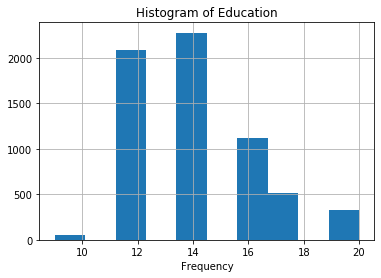

In [37]:
%matplotlib inline
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Educational level')
plt.xlabel('Frequency')

Text(0.5, 0, 'Frequency')

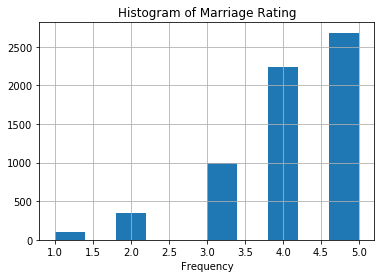

In [38]:
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.xlabel('Frequency')

Text(0.5, 0, 'Frequency')

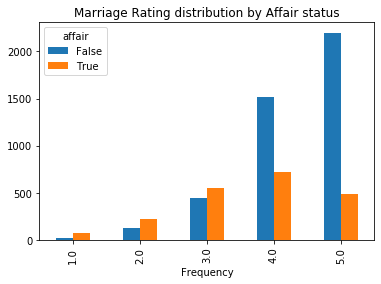

In [41]:
#Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.
pd.crosstab(dta.rate_marriage,dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating distribution by Affair status')
plt.xlabel('Marriage Rating')
plt.xlabel('Frequency')

Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

Text(0.5, 0, 'Percentage')

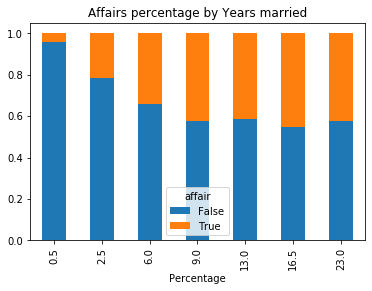

In [46]:
affairs_yrs_married=pd.crosstab(dta.yrs_married,dta.affair.astype(bool))
affairs_yrs_married.div(affairs_yrs_married.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
plt.title('Affairs percentage by Years married')
plt.xlabel('Years Married')
plt.xlabel('Percentage')

Prepare Data for Logistic Regression-

To prepare the data, we will add an intercept column as well as dummy variables for occupation and occupation_husb, since we are treating them as categorial variables. 

The dmatrices function from the patsy module can do that using formula language.

In [48]:
# add "affair" column: 1 represents having affairs, 0 represents not 
dta['affair'] = (dta.affairs > 0).astype(int)
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)',dta, return_type="dataframe")

In [50]:
y.head()

,affair
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [51]:
X.head()

,Intercept,C(occupation)[T.2.0],C(occupation)[T.3.0],C(occupation)[T.4.0],C(occupation)[T.5.0],C(occupation)[T.6.0],C(occupation_husb)[T.2.0],C(occupation_husb)[T.3.0],C(occupation_husb)[T.4.0],C(occupation_husb)[T.5.0],C(occupation_husb)[T.6.0],rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0


The column names for the dummy variables are ugly, so let's rename those-

In [52]:
X = X.rename(columns =
{'C(occupation)[T.2.0]':'occ_2',
'C(occupation)[T.3.0]':'occ_3',
'C(occupation)[T.4.0]':'occ_4',
'C(occupation)[T.5.0]':'occ_5',
'C(occupation)[T.6.0]':'occ_6',
'C(occupation_husb)[T.2.0]':'occ_husb_2',
'C(occupation_husb)[T.3.0]':'occ_husb_3',
'C(occupation_husb)[T.4.0]':'occ_husb_4',
'C(occupation_husb)[T.5.0]':'occ_husb_5',
'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [53]:
X.head()

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0


We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.

In [55]:
y=np.ravel(y)
y

array([1., 1., 1., ..., 0., 0., 0.])

Logistic Regression-


In [56]:
model=LogisticRegression()
model.fit(X,y)
#Check the accuracy on training set
model.score(X,y)

C:\Users\srija\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7251021049324536

In [57]:
y.mean()

0.3224945020420987

Only 32% of the women had affairs, which means that we could obtain 68% accuracy by always predicting "no". 
So we're doing better than the null error rate, but not by much.
Let's examine the coefficients to see what we learn-

In [59]:
pd.DataFrame(list(zip(X.columns,np.transpose(model.coef_))))

,0,1
0,Intercept,[1.3834936641888063]
1,occ_2,[0.06111361968611139]
2,occ_3,[0.3829748766511305]
3,occ_4,[0.1213508651926668]
4,occ_5,[0.7740386701893878]
5,occ_6,[0.23691875676710808]
6,occ_husb_2,[0.30252067161672236]
7,occ_husb_3,[0.4406801215505912]
8,occ_husb_4,[0.25547144698354385]
9,occ_husb_5,[0.2716195415727841]


From the above output we can say-Increases in marriage rating and religiousness correspond to a decrease in the likelihood of having an affair. 

For both the wife's occupation and the husband's occupation, the lowest likelihood of having an affair corresponds to the baseline occupation (student), since all of the dummy coefficients are positive.

Model Evaluation Using a Validation Set-

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [60]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.3, random_state = 0)
model2=LogisticRegression()
model2.fit(X_train,y_train)

C:\Users\srija\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We now need to predict class labels for the test set. We will also generate the class probabilities, just to take a look.

In [61]:
predicted=model2.predict(X_test)
predicted

array([1., 0., 0., ..., 0., 0., 0.])

In [62]:
probs=model2.predict_proba(X_test)
probs

array([[0.34434675, 0.65565325],
       [0.90319186, 0.09680814],
       [0.7208837 , 0.2791163 ],
       ...,
       [0.54206153, 0.45793847],
       [0.82162868, 0.17837132],
       [0.73725615, 0.26274385]])

As you can see, the classifier is predicting a 1 (having an affair) any time the probability in the second column is greater than 0.5.
Now let's generate some evaluation metrics-

In [64]:
print(metrics.accuracy_score(y_test,predicted))
print(metrics.roc_auc_score(y_test,probs[:,1]))

0.7293193717277487
0.7469001328830566


The accuracy is 73%, which is the same as we experienced when training and predicting on the same data.

We can also see the confusion matrix and a classification report with other metrics-

In [65]:
print(metrics.confusion_matrix(y_test,predicted))
print(metrics.classification_report(y_test,predicted))

[[1169  134]
 [ 383  224]]
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      1303
         1.0       0.63      0.37      0.46       607

    accuracy                           0.73      1910
   macro avg       0.69      0.63      0.64      1910
weighted avg       0.71      0.73      0.71      1910



Model Evaluation Using Cross-Validation-

Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [66]:
scores=cross_val_score(LogisticRegression(),X,y,scoring='accuracy',cv=10)
print(scores)
print(scores.mean())

C:\Users\srija\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\srija\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

[0.72370487 0.69858713 0.73940345 0.70800628 0.71428571 0.72684458
 0.72798742 0.70754717 0.75       0.75314465]
0.7249511270400758


Looks good. It's still performing at 73% accuracy.So our model is ready for prediction!

Can we predict the probability of an affair using our model?

Let's predict the probability of an affair for a random woman not present in the dataset. 

Assume she's a 25-year-old house wife who graduated college, has been married for 3 years, has 1 child, rates herself as strongly religious, rates her marriage as fair, and her husband is a farmer.

In [73]:
model.predict_proba(np.array([[1,0,0,1,0,0,1,0,0,0,0,3,25,3,1,4,16]]))

array([[0.77586125, 0.22413875]])

From our model we can predict that probability of an affair is 23%.